# Работа с Excel

Материалы:
* Макрушин С.В. Лекция 7: Работа с Excel
* https://docs.xlwings.org/en/stable/quickstart.html
* https://nbviewer.jupyter.org/github/pybokeh/jupyter_notebooks/blob/master/xlwings/Excel_Formatting.ipynb#search_text


## Задачи для совместного разбора

1. На листе "Рецептура" файла `себестоимостьА_в1.xlsx` для области "Пшеничный хлеб" рассчитать себестоимость всех видов продукции.

2. Результаты расчетов 1.1 сохранить в отдельном столбце области "Пшеничный хлеб"

3. Приблизить форматирование столбца, добавленного в задаче 2 к оформлению всей области.

4. Выполнить 3 с помощью "протягиваемых" формул.

## Лабораторная работа 7.1

1. Загрузите данные из файлов `reviews_sample.csv` (__ЛР2__) и `recipes_sample.csv` (__ЛР5__) в виде `pd.DataFrame`. Обратите внимание на корректное считывание столбца(ов) с индексами. Оставьте в таблице с рецептами следующие столбцы: `id`, `name`, `minutes`, `submitted`, `description`, `n_ingredients`

In [4]:
import pandas as pd
reviews = pd.read_csv("reviews_sample.csv")
reviews.rename(columns={"Unnamed: 0" : "Индексы"}, inplace=True)
recipes = pd.read_csv("recipes_sample.csv", usecols=["id","name","minutes","submitted","description","n_ingredients"])

2. Случайным образом выберите 5% строк из каждой таблицы и сохраните две таблицы на разные листы в один файл `recipes.xlsx`. Дайте листам названия "Рецепты" и "Отзывы", соответствующие содержанию таблиц. 

In [5]:
import xlwings as xw
wb = xw.Book()

sht = wb.sheets["Лист1"]
sht.name = "Отзывы"
sht.range("A1").value = reviews.sample(frac = 0.05)

sht = wb.sheets.add(name="Рецепты")
sht = wb.sheets["Рецепты"]
sht.range("A1").value = recipes.sample(frac = 0.05)

wb.save("recipes.xlsx")
wb.close()

3. Используя `xlwings`, добавьте на лист `Рецепты` столбец `seconds_assign`, показывающий время выполнения рецепта в секундах. Выполните задание при помощи присваивания массива значений диапазону ячеек.

In [6]:
wb = xw.Book("recipes.xlsx")
sht = wb.sheets("Рецепты")

last_row = sht.range('D1').end('down').row
mins = sht.range('D1:D' + str(last_row))[1:].value

secs = [int(i)*60 if i is not None else None for i in mins]
sht.range("H1").value = "Секунды"
sht.range("H2").options(transpose=True).value = secs

wb.save()
wb.close()

4. Используя `xlwings`, добавьте на лист `Рецепты` столбец `seconds_formula`, показывающий время выполнения рецепта в секундах. Выполните задание при помощи формул Excel.

In [7]:
wb = xw.Book("recipes.xlsx")
sht = wb.sheets("Рецепты")

last_row = sht.range('D1').end('down').row
fml = sht.range("I2").formula = f"=D2*60"
xw.Range("I2:I"+str(last_row)).formula = fml
sht.range("I1").value = "seconds_formula"

wb.save()
wb.close()

5. Сделайте названия всех добавленных столбцов полужирными и выровняйте по центру ячейки.

In [8]:
wb = xw.Book("recipes.xlsx")
sht = wb.sheets("Рецепты")

column_range = sht.range("H1:I1")
column_range.font.bold = True
column_range.autofit()

wb.save()
wb.close()

6. Раскрасьте ячейки столбца `minutes` в соответствии со следующим правилом: если рецепт выполняется быстрее 5 минут, то цвет - зеленый; от 5 до 10 минут - жёлтый; и больше 10 - красный.

In [9]:
wb = xw.Book("recipes.xlsx")
sht = wb.sheets("Рецепты")

for i in sht["D2"].expand("down"):
    if i.value < 5:
        i.color = (0, 255, 0)
    elif i.value > 10:
        i.color = (255,0,0)
    else:
        i.color = (255,255,0)

wb.save()
wb.close()

7. Добавьте на лист `Рецепты`  столбец `n_reviews`, содержащий кол-во отзывов для этого рецепта. Выполните задание при помощи формул Excel.

In [10]:
wb = xw.Book("recipes.xlsx")
recipes_sheet = wb.sheets["Рецепты"]
reviews_sheet = wb.sheets["Отзывы"]

# Определение диапазона столбца "C" на листе "Рецепты" от ячейки C2 до последней заполненной
last_row_recipes = recipes_sheet.range("C" + str(recipes_sheet.cells.last_cell.row)).end("up").row

recipes_sheet.range("J1").value = "n_reviews"

# Заполнение столбца "n_reviews" с использованием формулы COUNTIF
for i in range(2, last_row_recipes + 1):
    recipe_id = recipes_sheet.range(f"C{i}").value
    formula = f'=COUNTIF(Отзывы!$D:$D, {recipe_id})'
    recipes_sheet.range(f"J{i}").formula = formula
wb.save()

## Лабораторная работа 7.2

8. Напишите функцию `validate()`, которая проверяет соответствие всех строк из листа `Отзывы` следующим правилам:
    * Рейтинг - это число от 0 до 5 включительно
    * Соответствующий рецепт имеется на листе `Рецепты`
    
В случае несоответствия этим правилам, выделите строку красным цветом

In [5]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

file_path = 'recipes.xlsx'
sheet_recipes = 'Рецепты'
sheet_reviews = 'Отзывы'

recipes_df = pd.read_excel(file_path, sheet_name=sheet_recipes)
reviews_df = pd.read_excel(file_path, sheet_name=sheet_reviews)

# Функция для проверки рейтинга и наличия рецепта
def validate():
    workbook = load_workbook(filename=file_path)
    sheet = workbook[sheet_reviews]
    
    valid_recipe_ids = set(recipes_df['id'])
    
    red_fill = PatternFill(start_color='FFFF0000', end_color='FFFF0000', fill_type='solid')
    
    for index, row in reviews_df.iterrows():
        row_index_excel = index + 2  
        rating = row['rating']
        recipe_id = row['recipe_id']
        
        if not (0 <= rating <= 5) or recipe_id not in valid_recipe_ids:
            for col_index in range(1, len(row) + 1):
                sheet.cell(row=row_index_excel, column=col_index).fill = red_fill

    workbook.save(filename=file_path)

validate()


9. В файле `recipes_model.csv` находится модель данных предметной области "рецепты". При помощи пакета `csv` считайте эти данные. При помощи пакета `xlwings` запишите данные на лист `Модель` книги `recipes_model.xlsx`, начиная с ячейки `A2`, не используя циклы. Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука. 

In [12]:
import csv
import pandas as pd
import os


csv_file_path = 'recipes_model.csv'
data = []
with open(csv_file_path, newline='', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    data = list(csvreader)

df = pd.DataFrame(data)

excel_file_path = 'recipes_model.xlsx'
if not os.path.exists(excel_file_path):
    pd.DataFrame().to_excel(excel_file_path, index=False)

# Использование xlwings для записи данных в Excel
with xw.App(visible=False) as app:
    wb = xw.Book(excel_file_path)
    sheet_name = 'Модель'
    
    if sheet_name not in wb.sheets:
        wb.sheets.add(sheet_name)
    
    sheet = wb.sheets[sheet_name]
    
    sheet.range('A2').value = df.values.tolist()
    wb.save()

print(f"Данные успешно записаны в файл {excel_file_path} на лист 'Модель', начиная с ячейки A2.")


Данные успешно записаны в файл recipes_model.xlsx на лист 'Модель', начиная с ячейки A2.


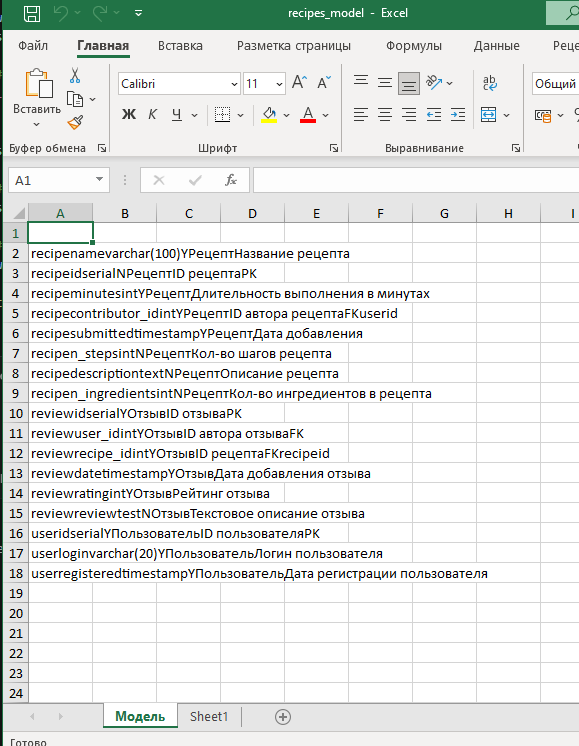

10. При помощи пакета `xlwings` добавьте в столбец J формулу для описания столбца на языке SQL. Формула должна реализовывать следующую логику:

    1\. в начале строки идут значения из столбцов В и C (значение столбца С приведено к верхнему регистру), разделенные пробелом
    
    2\. далее идут слова на основе столбца "Ключ"
        2.1 если в столбце "Ключ" указано значение "PK", то дальше через пробел идет ключевое слово "PRIMARY KEY"
        2.2 если в столбце "Ключ" указано значение "FK", то дальше через пробел идет ключевое слово "REFERENCES", затем значения столбцов H и I в формате "название_таблицы(название_столбца)"
        
    3\. если в столбце "Обязательно к заполнению" указано значение "Y" и в столбце "Ключ" указано не "PK", то дальше через пробел идет ключевое слово "NOT NULL".

Заполните этой формулой необходимое количество строк, используя "протягивание". Количество строк для протягивания определите на основе данных.

Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука.

In [13]:
excel_file_path = 'recipes_model.xlsx'
wb = xw.Book(excel_file_path)
sheet_name = 'Модель'
sheet = wb.sheets[sheet_name]

num_rows = sheet.range('A' + str(sheet.cells.last_cell.row)).end('up').row
for i in range(2, num_rows + 1):
    formula = f'=B{i} & " " & UPPER(C{i}) & " " & IF(D{i}="PK", "PRIMARY KEY", IF(D{i}="FK", "REFERENCES " & H{i} & "(" & I{i} & ", NOT NULL", ""))'
    sheet.range(f'J{i}').formula = formula

wb.save()

print(f"Формула успешно добавлена в столбец J для {num_rows - 1} строк.")

Формула успешно добавлена в столбец J для 17 строк.


11. При помощи пакета `xlwings` измените стилизацию листа `Модель`.
* для заголовков добавьте заливку цвета `00ccff`
* примените автоподбор ширины столбца;
* сделайте шрифт заголовков полужирным;
* добавьте таблице автофильтр.

Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука.

In [15]:
excel_file_path = 'recipes_model.xlsx'
wb = xw.Book(excel_file_path)
sheet_name = 'Модель'
sheet = wb.sheets[sheet_name]

header_range = sheet.range('A2').expand('right')
header_range.color = (0, 204, 255) 
header_range.api.Font.Bold = True  

sheet.range('A1').expand('table').columns.autofit()
sheet.range('A1').expand('table').api.AutoFilter

wb.save()

print("Стилизация листа 'Модель' успешно применена.")


Стилизация листа 'Модель' успешно применена.


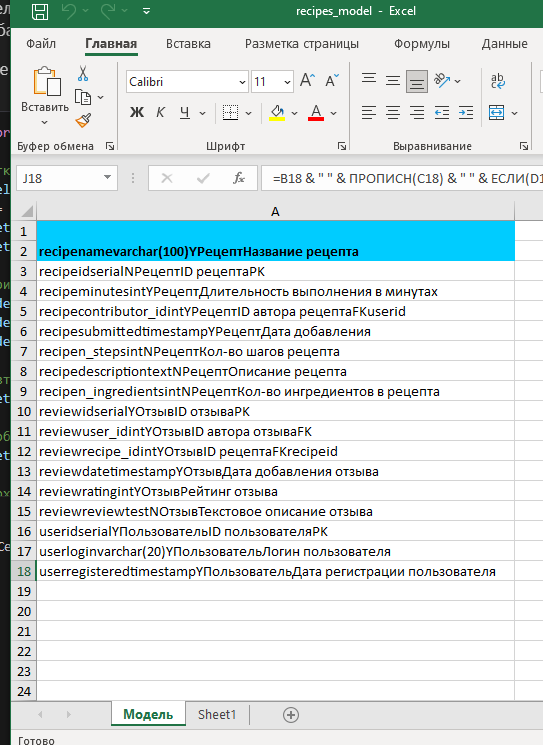